In [1]:
%cd ../

/Users/asmazaev/Projects/TensorAeroSpace


In [2]:
# from tensoraerospace.agent.narx.model import NARX

In [3]:
import numpy as np
import gymnasium as gym
import torch
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной периуд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(sinusoid(amplitude=5, tp=tp, frequency=5.0), [1, -1]) # Заданный сигнал


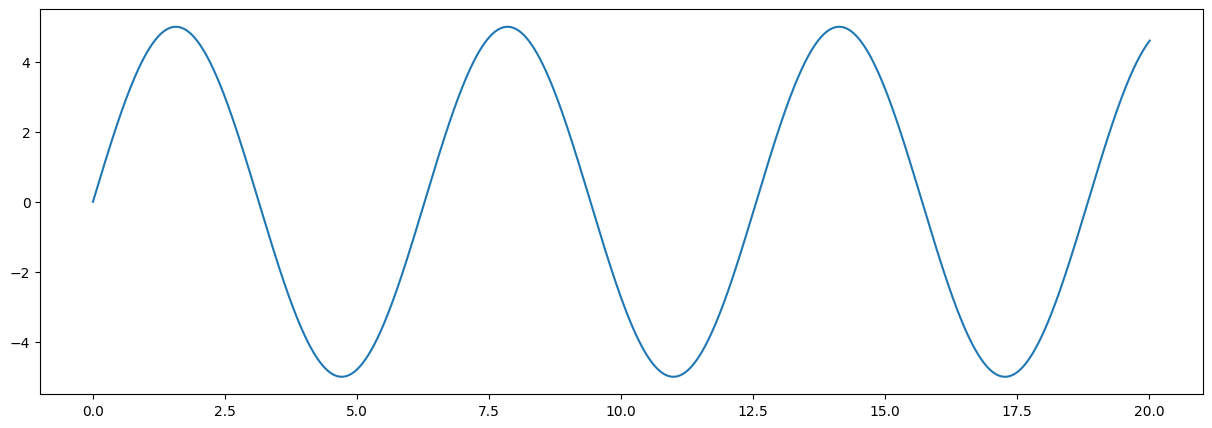

In [5]:
fig = plt.figure(figsize=(15,5))
plt.plot(tps, sinusoid(amplitude=0.01, tp=tp, frequency=5))

In [6]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.01  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=40, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=5)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],
               reference_signal=reference_signals,
               tracking_states=["alpha"])

# Сброс среды к начальному состоянию
state, info = env.reset()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [30]:
len(tp)

4001

In [7]:
env.action_space.low, env.action_space.high 

(array([[-25.]], dtype=float32), array([[25.]], dtype=float32))

In [8]:
from tensoraerospace.agent.a2c.narx import Actor, Mish, Critic, A2CLearner, Runner

In [9]:
env.action_space

Box(-25.0, 25.0, (1, 1), float32)

In [40]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)

learner = A2CLearner(actor, critic, entropy_beta=0.6)
runner = Runner(env, actor, writer=learner.writer)

In [41]:
state, info = env.reset()
state

array([0., 0.])

In [47]:
steps_on_memory = 100
episodes = 50000
episode_length = 4000
total_steps = (episode_length*episodes)//steps_on_memory

for i in tqdm(range(total_steps)):
    memory = runner.run(steps_on_memory)
    learner.learn(memory, runner.steps, discount_rewards=False)

  2%|▏         | 39613/2000000 [15:02<12:24:25, 43.89it/s]


KeyboardInterrupt: 

In [ ]:
action, reward, state, next_state, done = memory[31]

In [ ]:
reward

0

In [43]:
import os

# # Загрузка сохраненных весов
# actor.load_state_dict(torch.load('best_actor.pth'))
# critic.load_state_dict(torch.load('best_critic.pth'))
# env = gym.make('LinearLongitudinalF16-v0',
#                number_time_steps=number_time_steps, 
#                initial_state=[[0],[0],[0],[0]],
#                reference_signal=reference_signals,
#                tracking_states=["alpha"])

# Демонстрация обученного агента
num_demo_episodes = 5

for episode in range(num_demo_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    frames = 0
    prev_action = np.zeros(env.action_space.shape)
    while not done:
        dists = actor(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        actions = dists.sample().detach().data.numpy()
        actions_clipped = np.clip(actions, env.action_space.low.min(), env.action_space.high.max())
        next_state, reward, terminated, truncated, info= env.step(actions_clipped[0])
        prev_action = actions_clipped[0]  # Update the previous action
        done = terminated or truncated
        state = next_state
        total_reward += reward
        state = next_state
        frames +=1
    print(f"Demo Episode {episode}, Total Reward: {total_reward}, {frames}")


# Close the environment
# env.close()


Demo Episode 0, Total Reward: [-4367.25572672], 3999
Demo Episode 1, Total Reward: [-4818.25947791], 3999
Demo Episode 2, Total Reward: [-3813.96219724], 3999
Demo Episode 3, Total Reward: [-3651.53431069], 3999
Demo Episode 4, Total Reward: [-4480.64261543], 3999


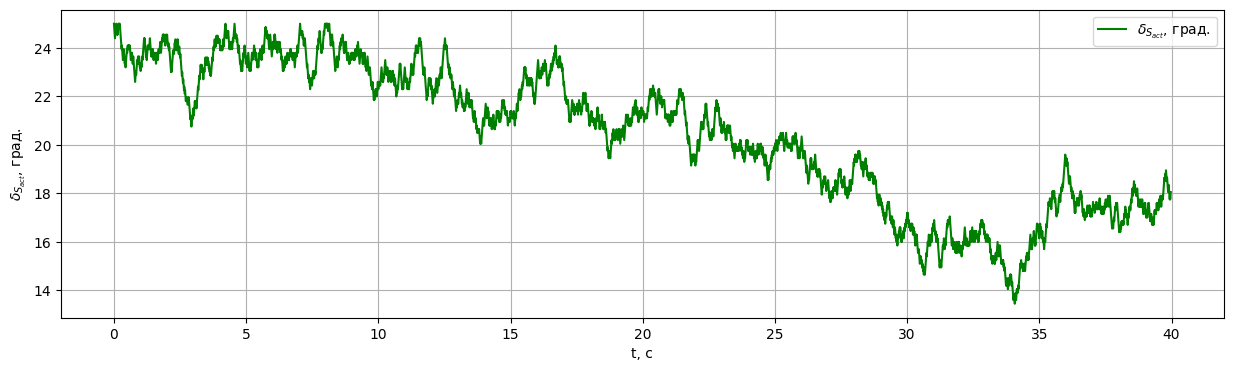

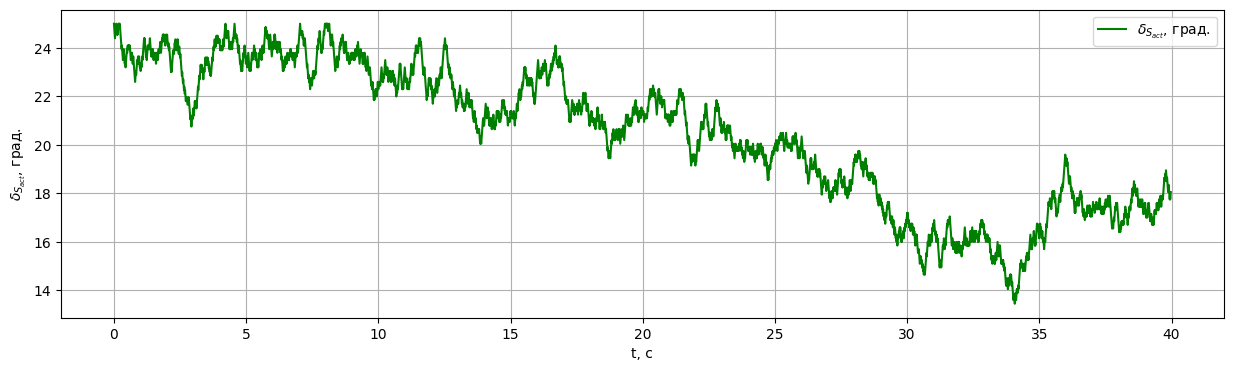

In [44]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

In [45]:
env.action_space.low

array([[-25.]], dtype=float32)

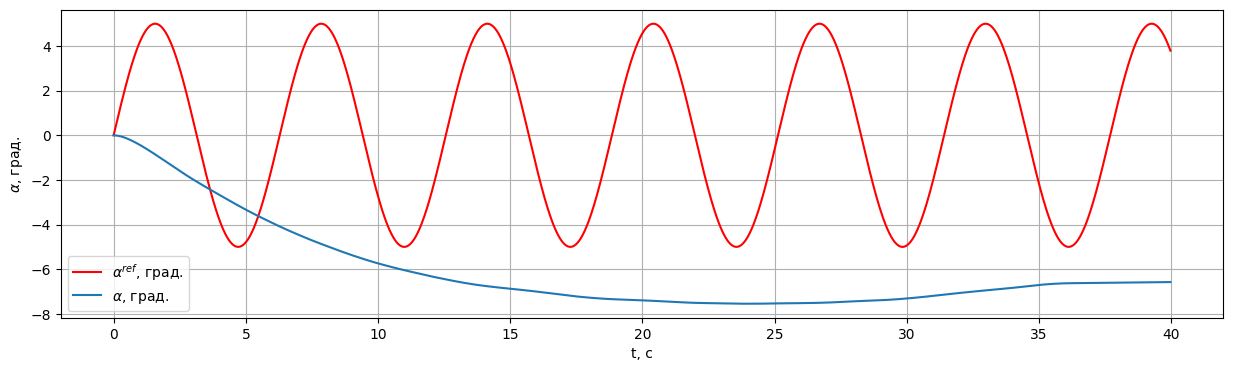

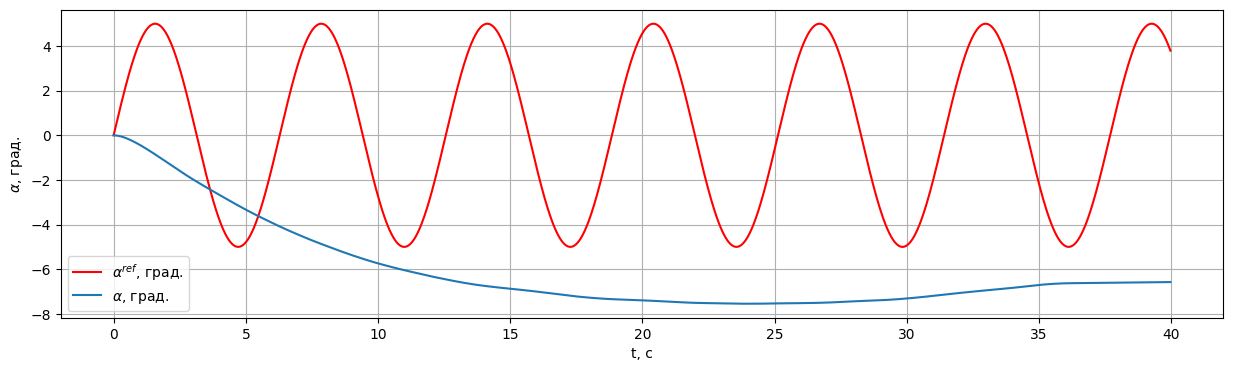

In [46]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))